In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pylops
from datetime import datetime
from glob import glob
from astropy.io import fits
import os
from itertools import chain
from tomograpy import project_3d, backproject_3d
from pylops.basicoperators import FunctionOperator
from pylops import LinearOperator, lsqr
from skimage.transform import resize

In [3]:
def z_rotation_matrix_3d(angle):
    return np.array([[[np.cos(angle), np.sin(angle), 0],
                      [-np.sin(angle), np.cos(angle), 0],
                      [0, 0, 1]]])

In [4]:
angles = list(range(5, 91, 5))
rad_angles = np.deg2rad(angles)

path = "/Users/jhughes/Desktop/data/synthetic COMPLETE data/5 degree/"
filenames = glob(path + "*.fits")
OFFSET = 32768.0
loaded_imgs = {np.deg2rad(angle): fits.open(os.path.join(path + f"comp_wl_284_ang_{angle}.fits"))[0].data for angle in angles}
radius = 300

img_size = 100 
cube_size = 100

RSUN = 285
SCALE_FACTOR = img_size / 1024
RSUN_SCALED = int(np.round(RSUN * SCALE_FACTOR))

In [5]:
angles = list(chain(range(70, 80), range(130, 140)))
rad_angles = np.deg2rad(angles)

path = "/Users/jhughes/Desktop/data/synthetic COMPLETE data/1 degree/"
filenames = glob(path + "*.fits")
OFFSET = 32768.0
loaded_imgs = {np.deg2rad(angle): fits.open(os.path.join(path + f"comp_wl_284_ang_{angle}.fits"))[0].data - OFFSET for angle in angles}
radius = 300

img_size = 100 
cube_size = 100

RSUN = 330
SCALE_FACTOR = img_size / 1024
RSUN_SCALED = int(np.round(RSUN * SCALE_FACTOR))

In [141]:
# angle = 90
# test_img = fits.open(os.path.join(path + f"comp_wl_284_ang_{angle}.fits"))[0].data #- OFFSET
# x, y = np.meshgrid(np.arange(test_img.shape[0]), np.arange(test_img.shape[1]))
# r = np.sqrt(np.square(x - 512) + np.square(y - 512))
# 
# test_img[r < 285] = 1400
# fig, ax = plt.subplots()
# im = ax.imshow(test_img, origin='lower', vmin=0, vmax=1300)
# fig.colorbar(im)

In [6]:
densities = np.zeros((cube_size, cube_size, cube_size), dtype=np.float32)
mask = np.ones((cube_size, cube_size, cube_size), dtype=bool)
x, y, z = np.meshgrid(np.arange(img_size), np.arange(img_size), np.arange(img_size))
r = np.sqrt(np.square(x - 50) + np.square(y - 50) + np.square(z - 50))
mask[r < RSUN_SCALED] = False

In [8]:
b = (0, 0, 0)
b = (-cube_size / 2, -cube_size / 2, -cube_size / 2)

delta = (1.0, 1.0, 1.0)
path_distance = 500.0

norms, xs, ys, zs, ds, imgs = [], [], [], [], [], []
#angles = np.array([0, 30])
for angle in rad_angles:
    angle = -angle
    t_angle = -angle + np.pi/2 #np.deg2rad(np.abs(90*np.cos(angle)))

    img_x = np.arange(img_size) - img_size / 2
    img_y = np.zeros((img_size, img_size))
    img_z = np.arange(img_size) - img_size / 2
    img_x, img_z = np.meshgrid(img_x, img_z)

    img_x, img_y, img_z = img_x.flatten(), img_y.flatten(), img_z.flatten()

    R = z_rotation_matrix_3d(t_angle)
    coords = (R @ np.stack([img_x, img_y, img_z]))[0]
    img_x, img_y, img_z = coords[0], coords[1], coords[2]
    img_x = radius * np.cos(angle) + img_x  # - img_size/2
    img_y = radius * np.sin(angle) + img_y  # - img_size/2

    xx = img_x.reshape((img_size, img_size)).astype(np.float32)
    yy = -img_y.reshape((img_size, img_size)).astype(np.float32)
    zz = img_z.reshape((img_size, img_size)).astype(np.float32)

    v1 = np.array([xx[0, 1] - xx[0, 0], yy[0, 1] - yy[0, 0], zz[0, 1] - zz[0, 0]])
    v2 = np.array([xx[1, 0] - xx[0, 0], yy[1, 0] - yy[0, 0], zz[1, 0] - zz[0, 0]])
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    normal = np.cross(v1, v2)
    normal = normal / np.linalg.norm(normal)

    norm = normal  # R @ np.array([1E-7, 1E-7, -1.0])
    norm[norm == 0] = 1E-6
    norms.append(norm)
    print(np.rad2deg(angle), np.rad2deg(t_angle), norm)

    d = 500
    img = resize(loaded_imgs[-angle], (img_size, img_size))  #project_3d(xx, yy, zz, densities, mask, b, delta, norm, d)
    xs.append(xx)
    ys.append(yy)
    zs.append(zz)
    ds.append(d)
    imgs.append(img.astype(np.float32))
imgs = np.array(imgs)

-70.0 160.0 [3.4201506e-01 9.3969452e-01 1.0000000e-06]
-71.0 161.0 [3.255599e-01 9.455215e-01 1.000000e-06]
-72.0 162.0 [3.0899498e-01 9.5106369e-01 1.0000000e-06]
-73.0 163.0 [2.923891e-01 9.562995e-01 1.000000e-06]
-74.0 164.0 [2.7563596e-01 9.6126211e-01 1.0000000e-06]
-75.0 165.00000000000003 [2.5882113e-01 9.6592534e-01 1.0000000e-06]
-76.0 166.0 [2.4194139e-01 9.7029090e-01 1.0000000e-06]
-77.0 167.0 [2.2494474e-01 9.7437149e-01 1.0000000e-06]
-78.0 167.99999999999997 [2.0791726e-01 9.7814643e-01 1.0000000e-06]
-79.0 169.0 [1.9082557e-01 9.8162401e-01 1.0000000e-06]
-130.0 220.0 [-6.427862e-01  7.660457e-01  1.000000e-06]
-131.0 221.0 [-6.5606087e-01  7.5470805e-01  1.0000000e-06]
-132.0 222.0 [-6.691190e-01  7.431553e-01  1.000000e-06]
-133.0 223.0 [-6.8199474e-01  7.3135710e-01  1.0000000e-06]
-134.0 224.0 [-6.9466233e-01  7.1933603e-01  1.0000000e-06]
-135.0 225.0 [-7.0711440e-01  7.0709914e-01  1.0000000e-06]
-136.0 226.0 [-7.1933573e-01  6.9466263e-01  1.0000000e-06]
-137.0

In [9]:
for angle, img in zip(rad_angles, imgs):
    fig, ax = plt.subplots()
    im = ax.imshow(img, vmin=0, vmax=1300)
    fig.colorbar(im)
    fig.savefig(f"/Users/jhughes/Desktop/projection_solar/{int(np.rad2deg(angle)):03d}.png")
    plt.close()

In [10]:
class Tomo(LinearOperator):
    def __init__(self, xs, ys, zs, norms, ds, b, delta, model_shape, mask, dtype=None):
        self.xs = xs
        self.ys = ys
        self.zs = zs
        self.norms = norms
        self.ds = ds
        self.b = b
        self.delta = delta
        self.model_shape = model_shape
        self.mask = mask
        super().__init__(dtype=np.dtype(dtype),
                         dims=self.model_shape,
                         dimsd=(len(self.xs), self.xs[0].shape[0], self.xs[0].shape[1]))

    def _matvec(self, densities):
        return np.array([project_3d(x, y, z, densities.reshape(self.model_shape).astype(np.float32),
                                    self.mask, self.b, self.delta, norm, d)
                for x, y, z, norm, d in zip(self.xs, self.ys, self.zs, self.norms, self.ds)]).flatten()

    def _rmatvec(self, imgs):
        densitiesi = np.zeros(self.model_shape, dtype=np.float32)
        for i, img in enumerate(imgs.reshape(len(self.xs), self.xs[0].shape[0], self.xs[0].shape[1])):
            # densitiesi += backproject_3d(self.xs[i], self.ys[i], self.zs[i], img,
            #                densitiesi,
            #                self.mask, self.b, self.delta, self.norms[i], self.ds[i], True)
            densitiesi += backproject_3d(self.xs[i], self.ys[i], self.zs[i], img,
                                         np.zeros_like(densitiesi).astype(np.float32),
                                         self.mask, self.b, self.delta, self.norms[i], self.ds[i], True)
        # return ((densitiesi - np.sum(img)) / (len(self.xs)-1)).astype(np.float32)
        return densitiesi.flatten().astype(np.float32) #/ densitiesi.shape[0] / len(self.xs)
        #return densitiesi.flatten().astype(np.float32)

print(len(xs))
op = Tomo(xs, ys, zs, norms, ds, b, delta, densities.shape, mask, dtype=np.float32)

Dop = [
    pylops.FirstDerivative(
        (cube_size, cube_size, cube_size), axis=0, edge=False, kind="backward", dtype=np.float32
    ),
    pylops.FirstDerivative(
        (cube_size, cube_size, cube_size), axis=1, edge=False, kind="backward", dtype=np.float32
    ),
    pylops.FirstDerivative(
        (cube_size, cube_size, cube_size), axis=2, edge=False, kind="backward", dtype=np.float32
    )
]
#
# # TV
# mu = 1.5
# lamda = [0.1, 0.1, 0.1]
# niter_out = 2
# niter_in = 1
#
# model = pylops.optimization.sparsity.splitbregman(
#     op,
#     imgs.ravel(),
#     Dop,
#     niter_outer=niter_out,
#     niter_inner=niter_in,
#     mu=mu,
#     epsRL1s=lamda,
#     tol=1e-4,
#     tau=1.0,
#     show=True,
#     **dict(iter_lim=5, damp=1e-4)
# )[0]

# model = op / imgs.flatten()
# model = pylops.optimization.leastsquares.regularized_inversion(
#     op, imgs.flatten(), Dop, **dict(iter_lim=10, show=True, atol=1E-8, btol=1E-8)
# )[0]
#
# model = pylops.optimization.basic.lsqr(op, imgs.flatten(),  x0=np.random.rand(*densities.flatten().shape).astype(np.float32),
#                                        niter=100, show=True, damp=0)[0]
model = pylops.optimization.basic.lsqr(op, imgs.flatten(), niter=100, show=True)[0]#, x0 = np.random.randint(0, 30, densities.shape))[0] # x0=densities.flatten() + 50 * np.random.rand(*densities.flatten().shape).astype(np.float32) - 25)[0]
                                       #                                        niter=100, show=True, damp=0)[0]
#model = pylops.optimization.basic.lsqr(op, imgs.flatten(), x0=densities.flatten(), niter=10, show=True)[0]
# model = pylops.optimization.basic.lsqr(op, imgs.flatten(), niter=1, show=True)[0]

# from pylops.optimization.cls_sparsity import FISTA
#
# fistasolver = FISTA(op)
#
# model = fistasolver.solve(imgs.flatten(), niter=2, show=True)[0]

#model = pylops.optimization.basic.cgls(op, imgs.flatten(), niter=10, show=True)[0]
model = model.reshape(densities.shape)


20
LSQR
------------------------------------------------------------------------------------------
The Operator Op has 200000 rows and 1000000 cols
damp = 0.00000000000000e+00     calc_var =      1
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08                 niter =      100
------------------------------------------------------------------------------------------
   Itn     x[0]      r1norm     r2norm   Compatible   LS     Norm A   Cond A
     0  0.0000e+00  1.314e+04  1.314e+04   1.0e+00  1.9e-03
     1  2.0418e-06  6.768e+03  6.768e+03   5.2e-01  4.0e-01  2.9e+01  1.0e+00
     2 -8.9022e-06  4.652e+03  4.652e+03   3.5e-01  3.2e-01  4.1e+01  2.2e+00
     3  1.3358e-06  3.198e+03  3.198e+03   2.4e-01  1.5e-01  5.5e+01  3.8e+00
     4 -8.4996e-07  2.479e+03  2.479e+03   1.9e-01  1.1e-01  6.2e+01  5.2e+00
     5  1.9254e-07  2.146e+03  2.146e+03   1.6e-01  7.2e-02  7.0e+01  6.7e+00
     6 -4.4224e-08  1.780e+03  1.780e+03   1.4e-01  6.8e-02  7.5e+01  8.9e+00
     7 

In [11]:
#model = np.load("/Users/jhughes/Desktop/projection_solar/cube.npy")
limit = np.nanpercentile(model, 99)

for i in range(cube_size):
    fig, ax = plt.subplots()
    im = ax.imshow(model[:, :, i], vmin=0, vmax=limit, origin='lower')
    fig.colorbar(im)
    fig.savefig(f"/Users/jhughes/Desktop/projection_solar/test_{i:03d}.png")
    plt.close()

reconstructions = op @ model.flatten()
reconstructions = reconstructions.reshape((len(xs), img_size, img_size))

for i, angle in enumerate(rad_angles):
    fig, axs = plt.subplots(ncols=2)
    im = axs[0].imshow(imgs[i], origin='lower')
    fig.colorbar(im)
    im = axs[1].imshow(reconstructions[i], origin='lower')
    fig.colorbar(im)
    fig.savefig(f"/Users/jhughes/Desktop/projection_solar/recon_{np.rad2deg(angle)}.png")
    plt.close()

In [12]:
i = 14
#angle = np.deg2rad(135)
POWER = 0.25
vmax = 500

fig, axs = plt.subplots(ncols=2)
im = axs[0].imshow(np.sign(imgs[i]) * np.power(np.abs(imgs[i]), POWER), vmin=0, vmax=np.power(vmax, POWER), origin='lower')
axs[0].set_title("Ground Truth")
#fig.colorbar(im)
im = axs[1].imshow(np.sign(reconstructions[i]) * np.power(np.abs(reconstructions[i]), POWER), vmin=0, vmax=np.power(vmax, POWER), origin='lower')
axs[1].set_title("Reconstructed Image")
#fig.colorbar(im)
fig.savefig(f"/Users/jhughes/Desktop/projection_solar/example.png")
plt.close()

In [180]:
np.save("/Users/jhughes/Desktop/projection_solar/model.npy", model)

In [176]:
i = 14
#angle = np.deg2rad(135)
POWER = 0.25
vmax = 50

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
im = axs[0].imshow(imgs[i], vmin=0, vmax=vmax, origin='lower')
axs[0].set_title("Ground Truth")
axs[0].set_axis_off()
#fig.colorbar(im)
im = axs[1].imshow(reconstructions[i], vmin=0, vmax=vmax, origin='lower')
axs[1].set_title("Reconstructed Image")
axs[1].set_axis_off()
#fig.colorbar(im)
fig.tight_layout()
fig.savefig(f"/Users/jhughes/Desktop/projection_solar/example.png")
plt.close()

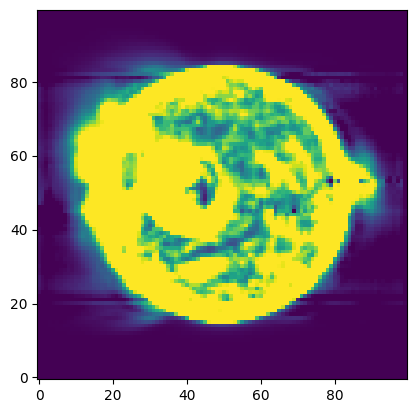

In [166]:
i = 14
#angle = np.deg2rad(135)

fig, ax = plt.subplots()
#fig.colorbar(im)
im = ax.imshow(reconstructions[i], vmin=0, vmax=10, origin='lower')
#fig.colorbar(im)

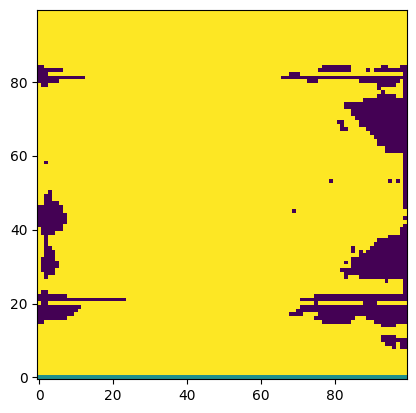

In [167]:
i = 14
#angle = np.deg2rad(135)

fig, ax = plt.subplots()
#fig.colorbar(im)
im = ax.imshow(np.sign(reconstructions[i]), origin='lower')
#fig.colorbar(im)